In [1]:
id_ = 'Zilionis_Klein_2019_NSCLC'
# id = 'Lambrechts_2018_LUAD_6149v1'
backup_dir = '/root/datos/maestria/netopaas/luca_explore/surgeries'
infercnv_dir = '/root/datos/maestria/netopaas/infercnv'
ikarus_dir = '/root/datos/maestria/netopaas/ikarus'
load_wilcoxon = True
load_gsea = True
load_gsea_heatmap = False
run_umap = False

In [2]:
# Parameters
id_ = "Laughney_Massague_2020_NSCLC"


# Cell Type Verification

## Libraries and Data

We want to check our tumor vs normal classifier. For that we will explore the state of our cells by different methods.

1. Via UMAP, how the types of cell cluster vs the tumor and normal labels. Also, if it is normal adjacent or tumor. Sample labels to discard batch effects.
2. Marker genes plots for these comparisons per cell type: (**TypeNormalPred_HT** vs **REST**) (**TypeNormalPred_TT** vs **REST**) (**TypeNormalPred_HT** vs **TypeNormalPred_TT**)
   (**TypeTumorPred_TT** vs **REST**) (**TypeTumorPred_TT** vs **TypeNormalPred_TT**)
3. Heatmaps With the above groups (**TumorPred_TT**, **NormalPred_TT**, **NormalPred_HT**) as  cell labels and hierarchical clustering in the genes. With genes chosen from the marker genes.
4. Prevalent gene ontologies for each of the groups above, considering also hallmark ontologies

In [3]:
import os
from pathlib import Path
import gdown

import sys
# This makes the working dir change apparently
sys.path.append("..")
import utils.functions as ut

import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
import pandas as pd
from scipy.sparse import csr_matrix

import anndata as ad
import scanpy as sc

In [4]:
# adata = sc.read_h5ad(f'{backup_dir}/combTumor_{id_}.h5ad')
adata = sc.read_h5ad(f'{backup_dir}/filtered_{id_}.h5ad')
adata

AnnData object with n_obs × n_vars = 29690 × 21595
    obs: 'sample', 'patient', 'origin', 'condition', 'tissue', 'n_counts', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mito', 'pct_counts_mito'
    var: 'n_counts', 'mito', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

### Types from infercnv dir

In [5]:
types = pd.read_csv(f'{infercnv_dir}/{id_}.csv')
types = types.rename(columns={'Unnamed: 0':'barcode_'})
types = types.rename(columns={'Level_2_transfered_label':'cell_type'})
types

,barcode_,cell_type
0,120703408884123_0,Lymphoid
1,120703409633700_0,Lymphoid
2,120703423507166_0,Lymphoid
3,120703423561070_0,Lymphoid
4,120703436306869_0,Lymphoid
...,...,...
29685,241114576481206_16,Myeloid
29686,241114577287974_16,Myeloid
29687,241114589031734_16,Myeloid
29688,241114589096668_16,Myeloid


In [6]:
adata.obs['barcode_'] = adata.obs.index
adata.obs = pd.merge(adata.obs, types, on='barcode_',
                    how='left')
adata.obs.cell_type = adata.obs.cell_type.fillna('Unknown')
adata.obs.columns

Index(['sample', 'patient', 'origin', 'condition', 'tissue', 'n_counts',
       'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mito',
       'pct_counts_mito', 'barcode_', 'cell_type'],
      dtype='object')

### Tumor prediction from ikarus

In [7]:
preds = pd.read_csv(f'{ikarus_dir}/{id_}.csv')
preds

,Unnamed: 0,final_pred
0,0,Normal
1,1,Normal
2,2,Normal
3,3,Normal
4,4,Normal
...,...,...
29685,29685,Normal
29686,29686,Normal
29687,29687,Normal
29688,29688,Normal


In [8]:
adata.obs['final_pred'] = list(preds.iloc[:,1])

In [9]:
adata.obs['origin']

0        tumor_primary
1        tumor_primary
2        tumor_primary
3        tumor_primary
4        tumor_primary
             ...      
29685           normal
29686           normal
29687           normal
29688           normal
29689           normal
Name: origin, Length: 29690, dtype: category
Categories (3, object): ['normal', 'tumor_metastasis', 'tumor_primary']

In [10]:
adata[np.logical_or(adata.obs['origin'].str.contains('normal'), adata.obs['origin']=='tumor_primary')].obs['origin'].value_counts()

origin
tumor_primary    14396
normal           10442
Name: count, dtype: int64

In [11]:
adata.layers['counts'] = adata.X

In [12]:
sc.pp.normalize_total(adata, target_sum=1e6)
sc.pp.log1p(adata)

## UMAP Clusters

We see similarities between cell types in normal tisse and tumor tissue. And  also what cell types are tumoral.

In [13]:
#papermill_description=UMAP
if run_umap:
    sc.tl.pca(adata)
    sc.pp.neighbors(adata)
    sc.tl.umap(adata)

In [14]:
if run_umap:
    fig, axs = plt.subplots(2, 2, figsize=(15, 10))
    
    sc.pl.umap(
        adata,
        color="cell_type",
        # legend_loc="on data",
        legend_fontoutline=2,
        ax=axs[0, 0],  # Specifies the subplot
        show=False  # Prevents showing the plot immediately
    )
    
    sc.pl.umap(
        adata,
        color="final_pred",
        # legend_loc="on data",
        legend_fontoutline=2,
        ax=axs[0, 1],  # Specifies the subplot
        show=False  # Prevents showing the plot immediately
    )
    
    sc.pl.umap(
        adata,
        color="origin",
        # legend_loc="on data",
        legend_fontoutline=2,
        ax=axs[1, 0],  # Specifies the subplot
        show=False  # Prevents showing the plot immediately
    )
    
    sc.pl.umap(
        adata,
        color="sample",
        # legend_loc="on data",
        legend_fontoutline=2,
        ax=axs[1, 1],  # Specifies the subplot
        show=False  # Prevents showing the plot immediately
    )
    
    # Display the entire figure with all plots
    plt.tight_layout()
    plt.show()

We can see that for the 'Tumor' prediciton there are mostly cells from patient 41, although there are many more samples from primary tumor.
This could be due to batch effects. So it is worthwile to run the prediction again with batch correction.

In [15]:
# adata.obs.groupby('leiden').count()
adata.obs.groupby('sample').count().iloc[:,0]

/tmp/ipykernel_27814/2910804369.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  adata.obs.groupby('sample').count().iloc[:,0]


sample
GSM3516662     188
GSM3516663    3675
GSM3516664     915
GSM3516665    2652
GSM3516666    2202
GSM3516667    3175
GSM3516668     543
GSM3516669     709
GSM3516670     513
GSM3516671     912
GSM3516672    3202
GSM3516673    3318
GSM3516674     282
GSM3516675    2214
GSM3516676    2708
GSM3516677    2148
GSM3516678     334
Name: patient, dtype: int64

## Marker Genes

Create a column that merges cell type, tissue and tumor pred

In [16]:
adata.obs['type_tissue'] = adata.obs.apply(lambda x: str(x['cell_type']) + '_' + 
                 ('HT' if 'normal' in x['origin'] else 'TT') + 
                 '_' + x['final_pred'], axis=1)
adata.obs['type_tissue'] = adata.obs['type_tissue'].astype('category')
adata.obs['type_tissue']

0        Lymphoid_TT_Normal
1        Lymphoid_TT_Normal
2        Lymphoid_TT_Normal
3        Lymphoid_TT_Normal
4        Lymphoid_TT_Normal
                ...        
29685     Myeloid_HT_Normal
29686     Myeloid_HT_Normal
29687     Myeloid_HT_Normal
29688     Myeloid_HT_Normal
29689    Lymphoid_HT_Normal
Name: type_tissue, Length: 29690, dtype: category
Categories (23, object): ['Airway epithelium_HT_Normal', 'Airway epithelium_TT_Normal', 'Airway epithelium_TT_Tumor', 'Alveolar epithelium_HT_Normal', ..., 'Smooth muscle_TT_Normal', 'Unknown_HT_Normal', 'Unknown_TT_Normal', 'Unknown_TT_Tumor']

In [17]:
# We dont get them with unique because it saves the NaN's
adata.obs.cell_type = adata.obs.cell_type.astype('category')
types = adata.obs.cell_type.cat.categories
num_types = len(types)
types

Index(['Airway epithelium', 'Alveolar epithelium', 'Blood vessels',
       'Fibroblast lineage', 'Lymphatic EC', 'Lymphoid', 'Mesothelium',
       'Myeloid', 'Smooth muscle', 'Unknown'],
      dtype='object')

In [18]:
adata.obs['type_tissue'].value_counts()

type_tissue
Lymphoid_TT_Normal               12099
Lymphoid_HT_Normal                5729
Myeloid_HT_Normal                 4022
Myeloid_TT_Normal                 3786
Airway epithelium_TT_Normal        885
Unknown_TT_Normal                  877
Alveolar epithelium_HT_Normal      410
Fibroblast lineage_TT_Normal       385
Alveolar epithelium_TT_Normal      312
Alveolar epithelium_TT_Tumor       308
Unknown_TT_Tumor                   271
Airway epithelium_HT_Normal        203
Blood vessels_TT_Normal            148
Airway epithelium_TT_Tumor         113
Smooth muscle_TT_Normal             49
Blood vessels_HT_Normal             36
Unknown_HT_Normal                   19
Fibroblast lineage_HT_Normal        16
Lymphatic EC_TT_Normal              13
Smooth muscle_HT_Normal              4
Lymphatic EC_HT_Normal               3
Lymphoid_TT_Tumor                    1
Mesothelium_TT_Normal                1
Name: count, dtype: int64

In [19]:
#papermill_description=WILCOXON_DE
# Get the groups that have more than 2 cells associated with them
valid_types = list(adata.obs['type_tissue'].value_counts().loc[lambda x: x > 2].index)
w_folder = 'wilcoxon_DE'

# Load

all_path = f'{w_folder}/all_{id_}.npy'
key = "wilcoxon"

if load_wilcoxon:
    adata.uns[key] = np.load(all_path, allow_pickle='TRUE').item()
else:
    sc.tl.rank_genes_groups(adata, 'type_tissue', method='wilcoxon', key_added = key,
                       groups=valid_types)
    np.save(all_path, adata.uns[key])

for type in types:
    tumor_tumor = type + '_TT_Tumor'
    normal_tumor = type + '_TT_Normal'
    normal_healthy = type + '_HT_Normal'

    differ_key = f"w_pair_{type}_differ"
    normal_key = f"w_pair_{type}_normal"
    differ_path =  f'{w_folder}/{differ_key}.npy'
    normal_path = f'{w_folder}/{normal_key}.npy'
    if load_wilcoxon:
        # We check for existance  here and not up there because there some datasets with no normal tissue
        if os.path.exists(differ_path):
            adata.uns[differ_key] = np.load(differ_path, allow_pickle='TRUE').item()
        if os.path.exists(normal_path):
            adata.uns[normal_key] = np.load(normal_path, allow_pickle='TRUE').item()
    else:
        if set([tumor_tumor, normal_tumor]).issubset(valid_types):
            sc.tl.rank_genes_groups(adata, 'type_tissue', method='wilcoxon', key_added = differ_key,
                                    groups=[tumor_tumor], reference=normal_tumor)
            np.save(differ_path, adata.uns[differ_key])
            
        if set([normal_tumor, normal_healthy]).issubset(valid_types):
            sc.tl.rank_genes_groups(adata, 'type_tissue', method='wilcoxon', key_added = normal_key,
                                    groups=[normal_tumor], reference=normal_healthy)
            np.save(normal_path, adata.uns[normal_key])

In [20]:
def cond_plot(adata, cond_types, valid_types, ax=None,
              key='wilcoxon', fontsize=9, titlesize=14, **kwds):
    print(cond_types)
    if set(cond_types).issubset(valid_types):
        ut.rank_genes_group(adata, cond_types[0], n_genes=n_genes,
                            ax=ax, sharey=False, key=key, show=False,
                            fontsize=fontsize, titlesize=titlesize)
    else:
        # Draw an empty plot with a message
        ax.text(0.5, 0.5, f'Missing cells: {cond_types}', color='red', 
                       ha='center', va='center', transform=ax.transAxes)
        ax.axis('off')

In [21]:
valid_types

['Lymphoid_TT_Normal',
 'Lymphoid_HT_Normal',
 'Myeloid_HT_Normal',
 'Myeloid_TT_Normal',
 'Airway epithelium_TT_Normal',
 'Unknown_TT_Normal',
 'Alveolar epithelium_HT_Normal',
 'Fibroblast lineage_TT_Normal',
 'Alveolar epithelium_TT_Normal',
 'Alveolar epithelium_TT_Tumor',
 'Unknown_TT_Tumor',
 'Airway epithelium_HT_Normal',
 'Blood vessels_TT_Normal',
 'Airway epithelium_TT_Tumor',
 'Smooth muscle_TT_Normal',
 'Blood vessels_HT_Normal',
 'Unknown_HT_Normal',
 'Fibroblast lineage_HT_Normal',
 'Lymphatic EC_TT_Normal',
 'Smooth muscle_HT_Normal',
 'Lymphatic EC_HT_Normal']

['Airway epithelium_TT_Tumor']


['Airway epithelium_TT_Tumor', 'Airway epithelium_TT_Normal']
['Alveolar epithelium_TT_Tumor']
['Alveolar epithelium_TT_Tumor', 'Alveolar epithelium_TT_Normal']
['Blood vessels_TT_Tumor']
['Blood vessels_TT_Tumor', 'Blood vessels_TT_Normal']
['Fibroblast lineage_TT_Tumor']
['Fibroblast lineage_TT_Tumor', 'Fibroblast lineage_TT_Normal']
['Lymphatic EC_TT_Tumor']
['Lymphatic EC_TT_Tumor', 'Lymphatic EC_TT_Normal']
['Lymphoid_TT_Tumor']
['Lymphoid_TT_Tumor', 'Lymphoid_TT_Normal']
['Mesothelium_TT_Tumor']
['Mesothelium_TT_Tumor', 'Mesothelium_TT_Normal']
['Myeloid_TT_Tumor']
['Myeloid_TT_Tumor', 'Myeloid_TT_Normal']
['Smooth muscle_TT_Tumor']
['Smooth muscle_TT_Tumor', 'Smooth muscle_TT_Normal']
['Unknown_TT_Tumor']
['Unknown_TT_Tumor', 'Unknown_TT_Normal']


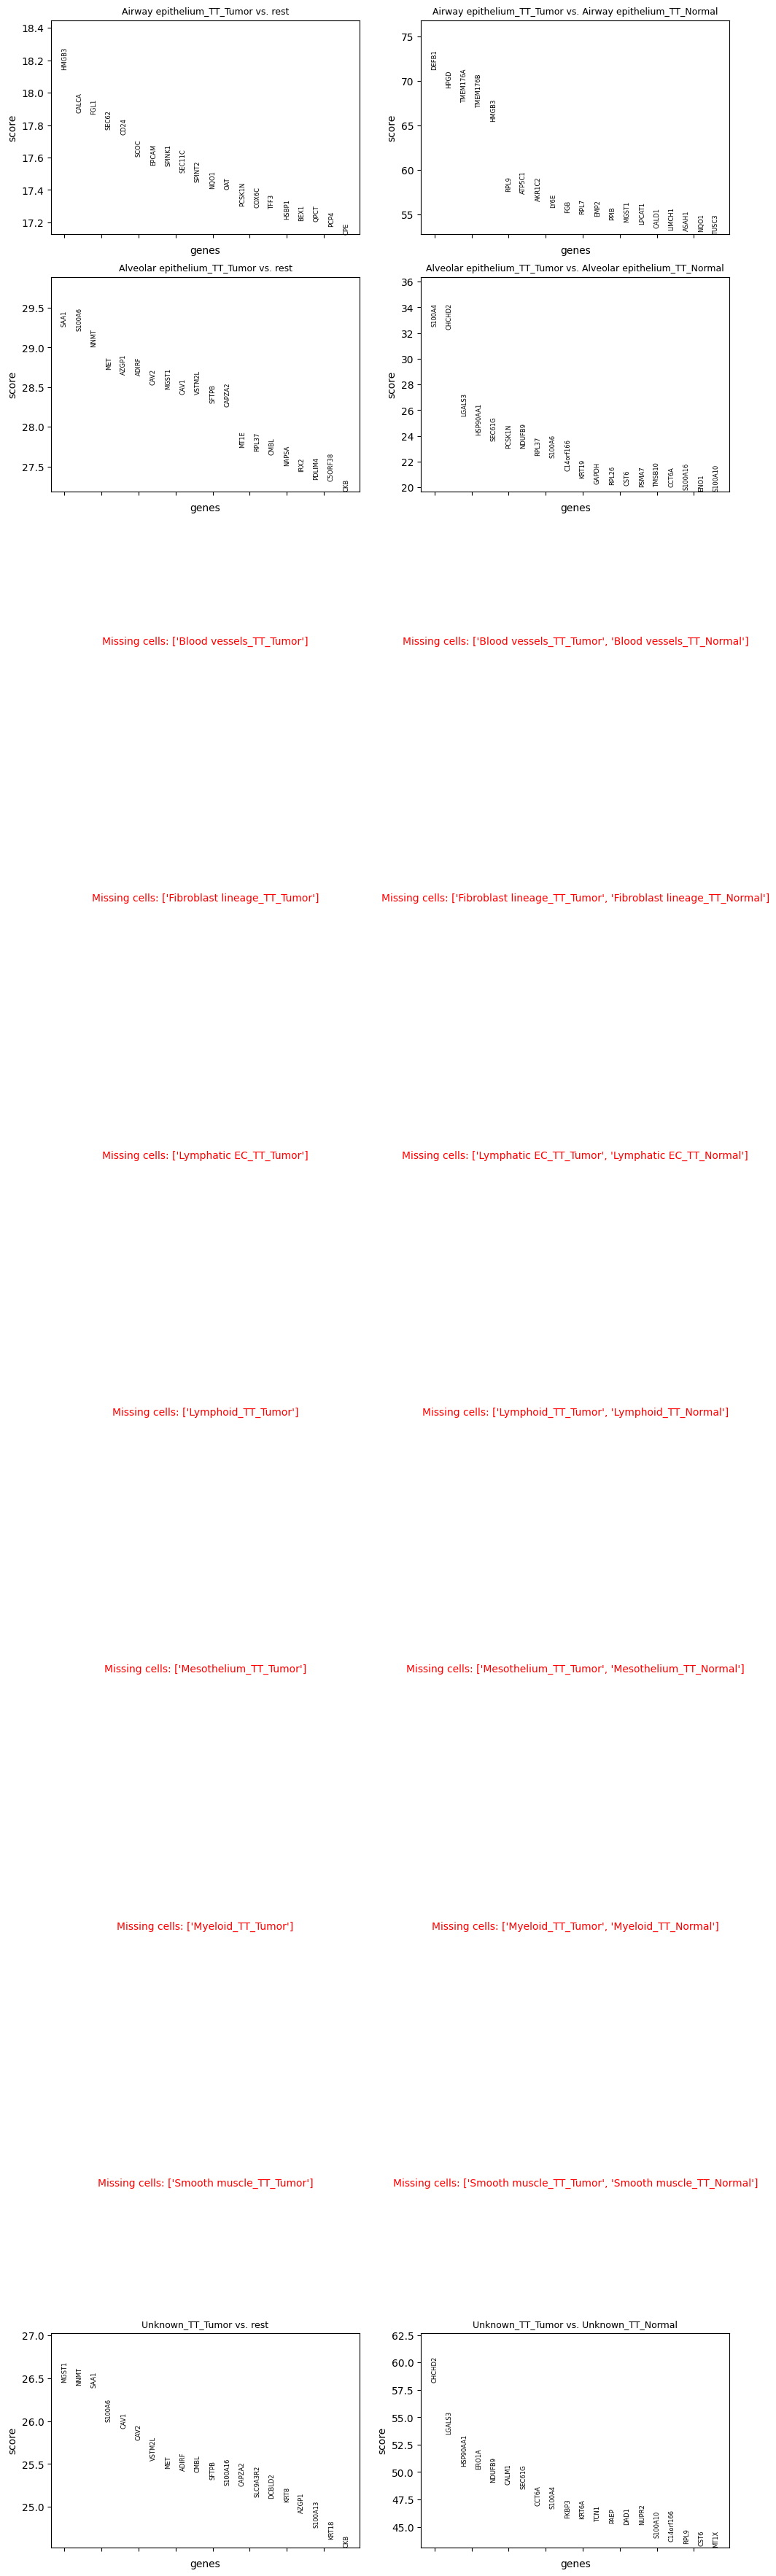

In [22]:
if(adata.obs.origin.str.contains('tumor').any()):
    fig, axs = plt.subplots(num_types, 2, figsize=(12, 4.5*num_types))
    n_genes = 20
    for i, type in enumerate(types):
        tumor_tumor = type + '_TT_Tumor'
        normal_tumor = type + '_TT_Normal'
        titlesize = 9
        fontsize = 6
    
        
        cond_plot(adata, [tumor_tumor], valid_types, n_genes=n_genes,
                         ax= axs[i, 0], sharey=False, key="wilcoxon", show=False,
                         fontsize=fontsize, titlesize=titlesize)
        cond_plot(adata, [tumor_tumor, normal_tumor], valid_types, n_genes=n_genes, ax= axs[i, 1],
                                key=f"w_pair_{type}_differ", show=False,
                         fontsize=fontsize, titlesize=titlesize)
    
    # Display the entire figure with all plots
    plt.show()
else:
    from warnings import warn
    warn('NO TUMOR TISSUES!?!?!?!!?')

In [23]:
adata.obs.origin.str.contains('normal').any()

True

['Airway epithelium_HT_Normal']
['Airway epithelium_TT_Normal']
w_pair_Airway epithelium_normal
['Airway epithelium_TT_Normal', 'Airway epithelium_HT_Normal']


['Alveolar epithelium_HT_Normal']
['Alveolar epithelium_TT_Normal']
w_pair_Alveolar epithelium_normal
['Alveolar epithelium_TT_Normal', 'Alveolar epithelium_HT_Normal']
['Blood vessels_HT_Normal']
['Blood vessels_TT_Normal']


w_pair_Blood vessels_normal
['Blood vessels_TT_Normal', 'Blood vessels_HT_Normal']
['Fibroblast lineage_HT_Normal']
['Fibroblast lineage_TT_Normal']


w_pair_Fibroblast lineage_normal
['Fibroblast lineage_TT_Normal', 'Fibroblast lineage_HT_Normal']
['Lymphatic EC_HT_Normal']
['Lymphatic EC_TT_Normal']
w_pair_Lymphatic EC_normal
['Lymphatic EC_TT_Normal', 'Lymphatic EC_HT_Normal']
['Lymphoid_HT_Normal']


['Lymphoid_TT_Normal']
w_pair_Lymphoid_normal
['Lymphoid_TT_Normal', 'Lymphoid_HT_Normal']
['Mesothelium_HT_Normal']
['Mesothelium_TT_Normal']
w_pair_Mesothelium_normal
['Mesothelium_TT_Normal', 'Mesothelium_HT_Normal']
['Myeloid_HT_Normal']
['Myeloid_TT_Normal']


w_pair_Myeloid_normal
['Myeloid_TT_Normal', 'Myeloid_HT_Normal']
['Smooth muscle_HT_Normal']


['Smooth muscle_TT_Normal']
w_pair_Smooth muscle_normal
['Smooth muscle_TT_Normal', 'Smooth muscle_HT_Normal']
['Unknown_HT_Normal']
['Unknown_TT_Normal']
w_pair_Unknown_normal
['Unknown_TT_Normal', 'Unknown_HT_Normal']


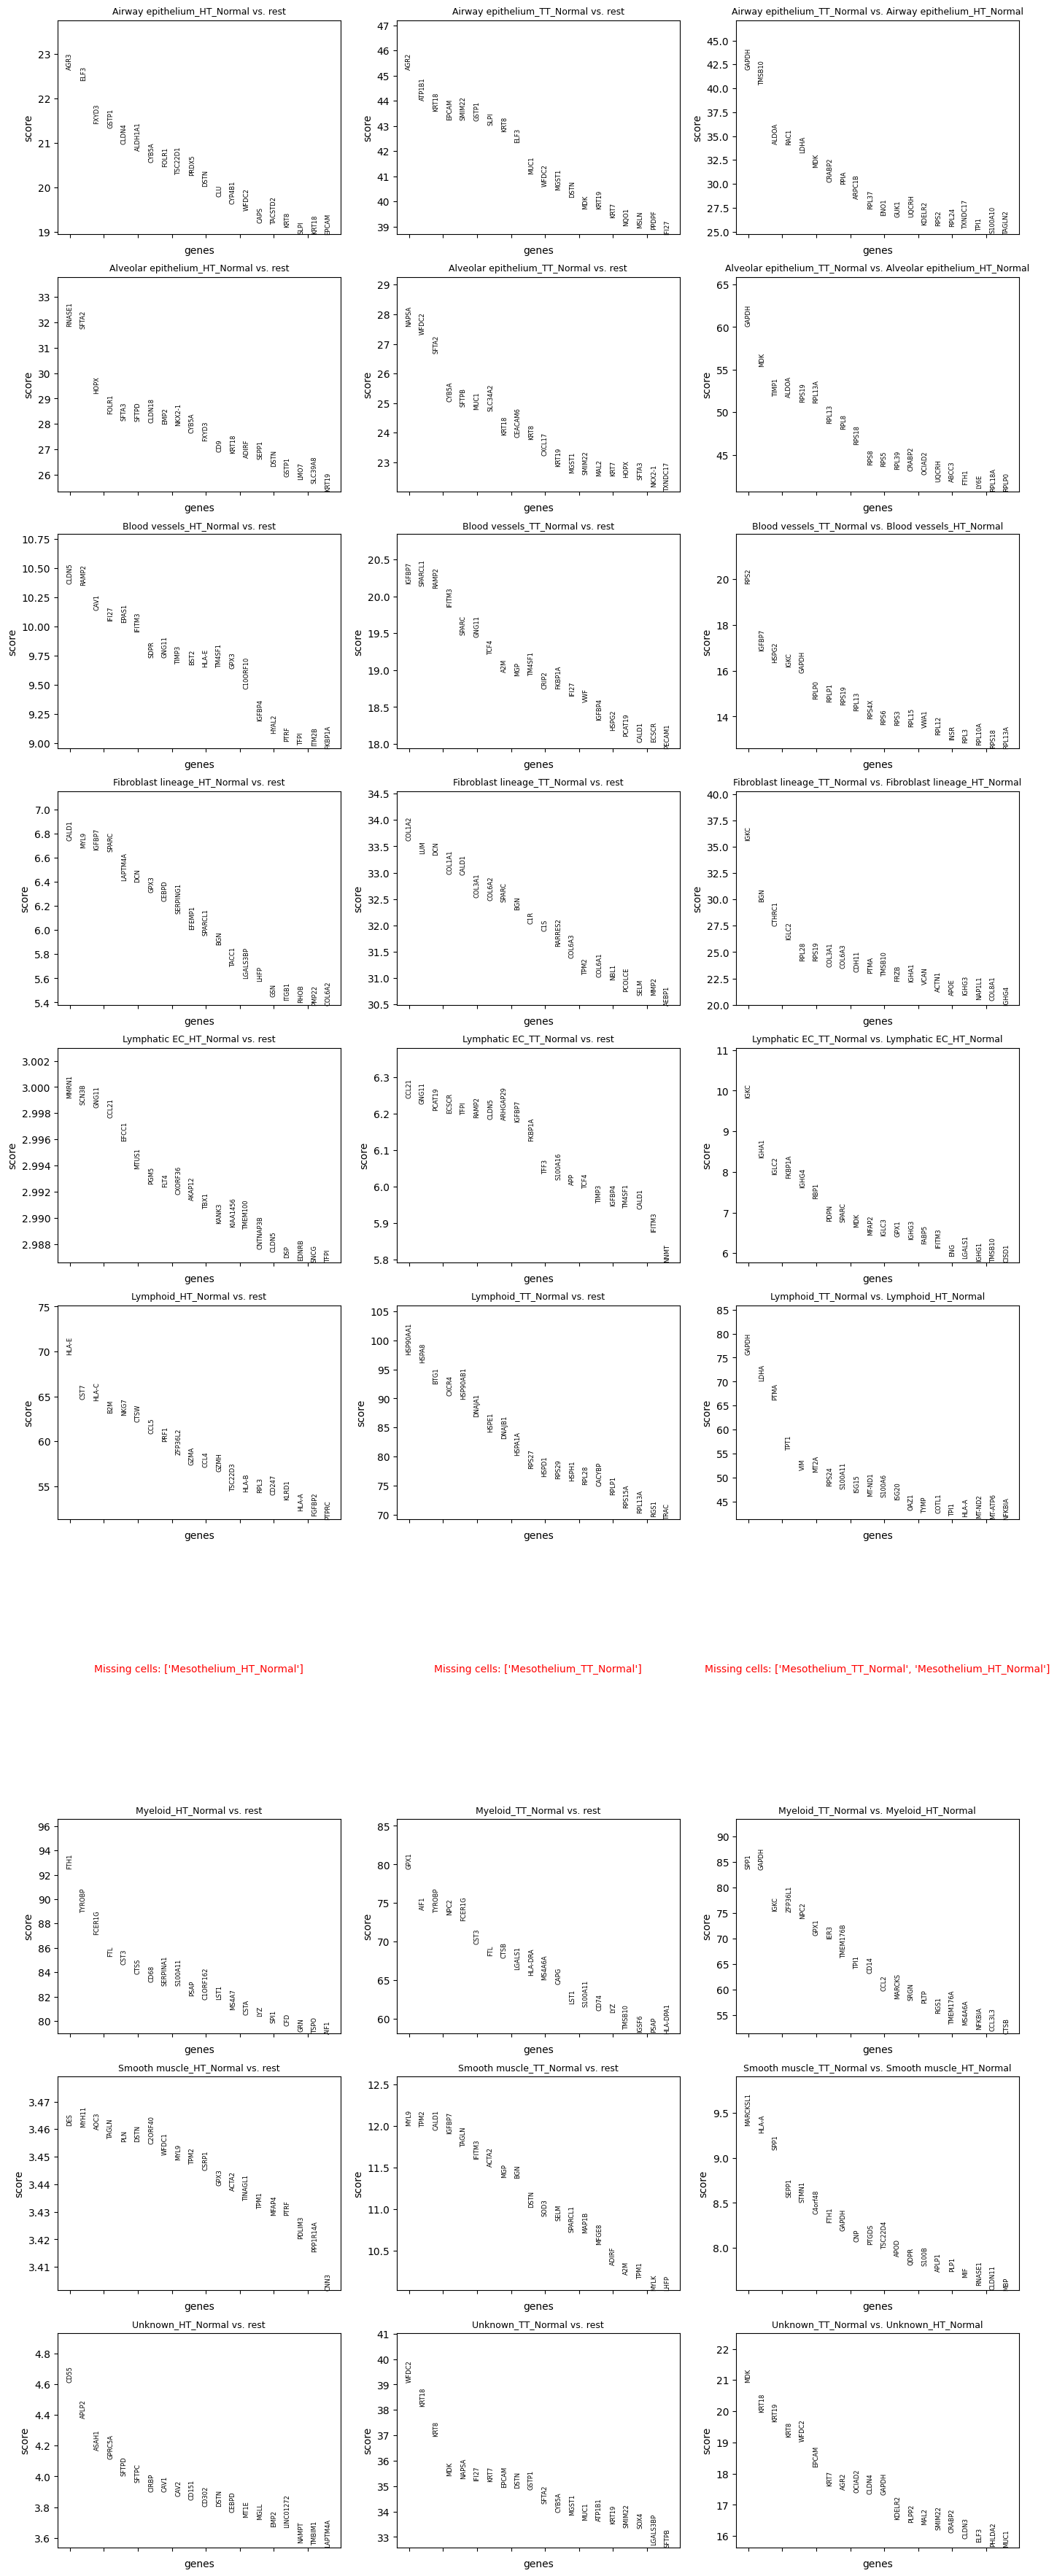

In [24]:
from warnings import warn

if(adata.obs.origin.str.contains('normal').any()):
    fig, axs = plt.subplots(num_types, 3, figsize=(17, 4.5*num_types))
    n_genes = 20
    for i, type in enumerate(types):
        normal_healthy = type + '_HT_Normal'
        normal_tumor = type + '_TT_Normal'
        titlesize = 9
        fontsize = 6
    
        
        cond_plot(adata, [normal_healthy], valid_types, n_genes=n_genes,
                         ax= axs[i, 0], sharey=False, key="wilcoxon", show=False,
                         fontsize=fontsize, titlesize=titlesize)
        cond_plot(adata, [normal_tumor], valid_types, n_genes=n_genes,
                                ax= axs[i, 1], sharey=False, key="wilcoxon", show=False,
                         fontsize=fontsize, titlesize=titlesize)
        print(f"w_pair_{type}_normal")
        cond_plot(adata, [normal_tumor, normal_healthy], valid_types, n_genes=n_genes, ax= axs[i, 2],
                                key=f"w_pair_{type}_normal", show=False,
                         fontsize=fontsize, titlesize=titlesize)
    
    # Display the entire figure with all plots
    plt.show()
else:
    warn('No healthy tissue!')
    

## Heatmaps

         Falling back to preprocessing with `sc.pp.pca` and default params.


/usr/local/lib/python3.11/site-packages/scanpy/plotting/_anndata.py:1067: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if isinstance(groupby, str) and is_categorical_dtype(adata.obs[groupby]):
/usr/local/lib/python3.11/site-packages/scanpy/tools/_dendrogram.py:105: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(adata.obs[group]):
/usr/local/lib/python3.11/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


categories: Airway epithelium_HT_Normal, Airway epithelium_TT_Normal, Airway epithelium_TT_Tumor, etc.
var_group_labels: Lymphoid_TT_Normal, Lymphoid_HT_Normal, Myeloid_HT_Normal, etc.


/usr/local/lib/python3.11/site-packages/scanpy/tools/_dendrogram.py:133: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_df = rep_df.groupby(level=0).mean()


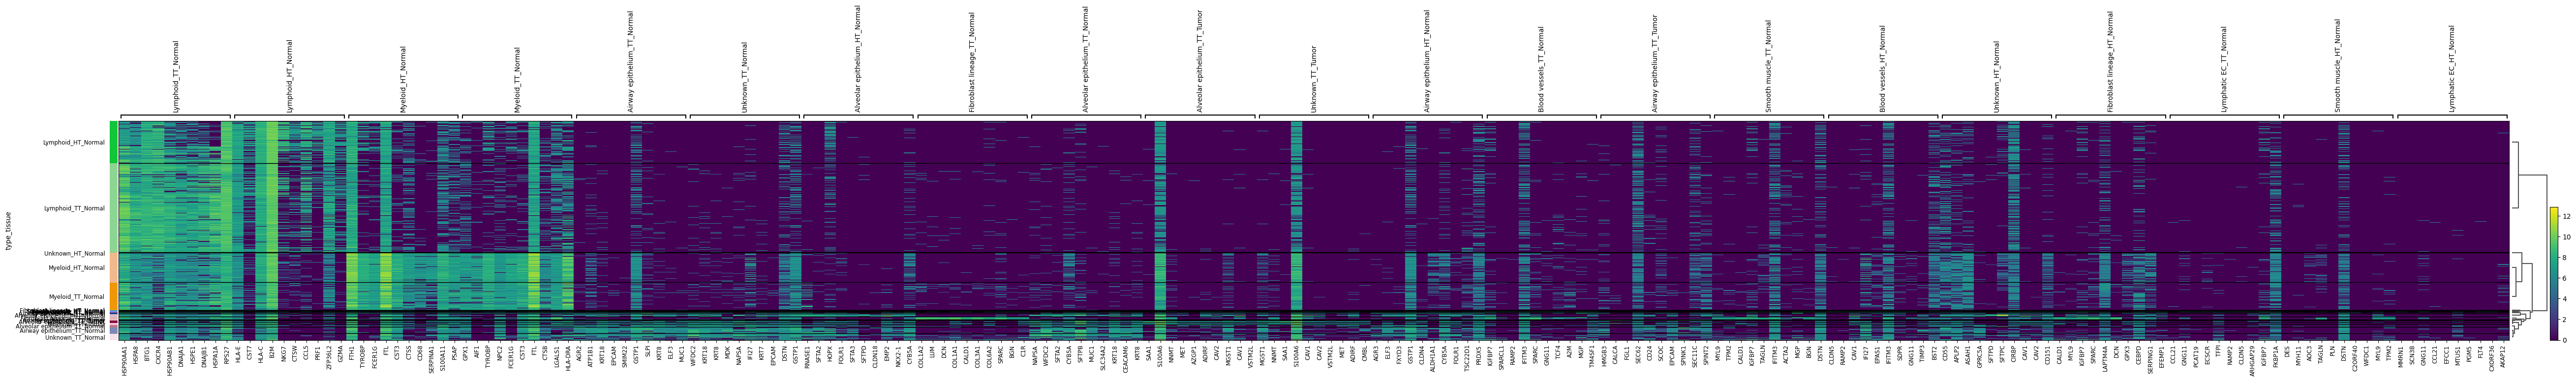

In [25]:
sc.pl.rank_genes_groups_heatmap(adata, show_gene_labels=True, key='wilcoxon')

## GSEA

In [26]:
from gprofiler import GProfiler
import gseapy
import seaborn as sns
gp = GProfiler(return_dataframe=True, user_agent='INMEGEN')

In [27]:
# gen_list = adata.uns['wilcoxon']['names']['Airway epithelium_TT_Tumor'][100:]
# enrich = gp.profile(list(gen_list), sources=['GO:BP'], organism="hsapiens")
# enrich.iloc[:25,:]

In [28]:
#  Download Gene symbols
if not os.path.exists('h.all.v2023.2.Hs.symbols.gmt'):
    ! wget https://data.broadinstitute.org/gsea-msigdb/msigdb/release/2023.2.Hs/h.all.v2023.2.Hs.symbols.gmt

#  Gene entrez
# if not os.path.exists('h.all.v2023.2.Hs.entrez.gmt'):
# ! wget https://data.broadinstitute.org/gsea-msigdb/msigdb/release/2023.2.Hs/h.all.v2023.2.Hs.entrez.gmt

In [29]:
valid_types = list(adata.obs['type_tissue'].value_counts().loc[lambda x: x > 2].index)

In [30]:
from typing import List

def get_gseas_df(adata: ad.AnnData, valid_types: List[str], types: List[str], id_: str, load_gsea: bool = False) -> pd.DataFrame:
    """
    Generates a combined DataFrame from GSEA results for different cell types.

    Args:
    adata (ad.AnnData): An AnnData object containing the dataset.
    valid_types (List[str]): A list of valid cell types to filter the cell types.
    types (List[str]): A list of cell types to be considered for analysis.
    id_ (str): Identifier used in generating the GSEA path.
    load_gsea (bool, optional): Flag to load existing GSEA results. Defaults to False.

    Returns:
    pd.DataFrame: A combined DataFrame with GSEA results pivoted by cell type and hallmark.

    The function uses the provided 'types', intersects them with 'valid_types',
    and computes GSEA for each type. The final DataFrame is a pivot table with cell types as rows
    and GSEA hallmarks as columns.
    """
    # Intersect types with valid types
    types = set(types).intersection(valid_types)

    gsea_folder = 'gseapy_gsea'
    dfs = []

    for type in types:
        wilco = adata.uns['wilcoxon']
        gsea_path = f'{gsea_folder}/{type}_{id_}.npz'

        # Generate gene scores
        gene_scores = {gene: wilco['scores'][type][i] for i, gene in enumerate(wilco['names'][type])}
        gene_scores = pd.Series(gene_scores)

        # Run GSEA
        if load_gsea:
            gseas = np.load(gsea_path, allow_pickle='TRUE').item()
        else:
            pre_res = gseapy.prerank(rnk=gene_scores, gene_sets='h.all.v2023.2.Hs.symbols.gmt',
                                     processes=20, permutation_num=100, seed=6, no_plot=True)
            gseas = pre_res.res2d
            np.save(gsea_path, gseas)

        data1 = {'hallmark': list(gseas['Term'].str.slice(9)), 'score': list(gseas['NES'])}
        df_celltype1 = pd.DataFrame(data1)
        df_celltype1['cell_type'] = type
        dfs.append(df_celltype1)

    # Combine all DataFrames
    combined_df = pd.concat(dfs).reset_index(drop=True).pivot(index='cell_type', columns='hallmark', values='score')
    return combined_df

In [31]:
#papermill_description=GSEA
gsea_folder = 'gseapy_gsea'
gsea_path = f'{gsea_folder}/heatmap_{id_}.csv'

if load_gsea_heatmap:
    combined_df = pd.read_csv(gsea_path, index_col=0)
else:
    types = adata.obs.loc[:, 'type_tissue'].unique()
    combined_df = get_gseas_df(adata, valid_types, types, id_, load_gsea=False)
    combined_df.to_csv(gsea_path)

/tmp/ipykernel_27814/760898386.py:39: DeprecationWarning: processes is deprecated; use threads
  pre_res = gseapy.prerank(rnk=gene_scores, gene_sets='h.all.v2023.2.Hs.symbols.gmt',
2024-02-21 15:30:52,950 [WARNING] Duplicated values found in preranked stats: 41.56% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


/tmp/ipykernel_27814/760898386.py:39: DeprecationWarning: processes is deprecated; use threads
  pre_res = gseapy.prerank(rnk=gene_scores, gene_sets='h.all.v2023.2.Hs.symbols.gmt',
2024-02-21 15:30:55,104 [WARNING] Duplicated values found in preranked stats: 49.22% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


/tmp/ipykernel_27814/760898386.py:39: DeprecationWarning: processes is deprecated; use threads
  pre_res = gseapy.prerank(rnk=gene_scores, gene_sets='h.all.v2023.2.Hs.symbols.gmt',
2024-02-21 15:30:57,131 [WARNING] Duplicated values found in preranked stats: 45.67% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


/tmp/ipykernel_27814/760898386.py:39: DeprecationWarning: processes is deprecated; use threads
  pre_res = gseapy.prerank(rnk=gene_scores, gene_sets='h.all.v2023.2.Hs.symbols.gmt',
2024-02-21 15:30:58,469 [WARNING] Duplicated values found in preranked stats: 26.40% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


/tmp/ipykernel_27814/760898386.py:39: DeprecationWarning: processes is deprecated; use threads
  pre_res = gseapy.prerank(rnk=gene_scores, gene_sets='h.all.v2023.2.Hs.symbols.gmt',
2024-02-21 15:31:00,944 [WARNING] Duplicated values found in preranked stats: 18.58% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


/tmp/ipykernel_27814/760898386.py:39: DeprecationWarning: processes is deprecated; use threads
  pre_res = gseapy.prerank(rnk=gene_scores, gene_sets='h.all.v2023.2.Hs.symbols.gmt',
2024-02-21 15:31:02,882 [WARNING] Duplicated values found in preranked stats: 24.09% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


/tmp/ipykernel_27814/760898386.py:39: DeprecationWarning: processes is deprecated; use threads
  pre_res = gseapy.prerank(rnk=gene_scores, gene_sets='h.all.v2023.2.Hs.symbols.gmt',
2024-02-21 15:31:04,298 [WARNING] Duplicated values found in preranked stats: 26.70% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


/tmp/ipykernel_27814/760898386.py:39: DeprecationWarning: processes is deprecated; use threads
  pre_res = gseapy.prerank(rnk=gene_scores, gene_sets='h.all.v2023.2.Hs.symbols.gmt',
2024-02-21 15:31:06,340 [WARNING] Duplicated values found in preranked stats: 16.31% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


/tmp/ipykernel_27814/760898386.py:39: DeprecationWarning: processes is deprecated; use threads
  pre_res = gseapy.prerank(rnk=gene_scores, gene_sets='h.all.v2023.2.Hs.symbols.gmt',
2024-02-21 15:31:08,171 [WARNING] Duplicated values found in preranked stats: 16.77% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


/tmp/ipykernel_27814/760898386.py:39: DeprecationWarning: processes is deprecated; use threads
  pre_res = gseapy.prerank(rnk=gene_scores, gene_sets='h.all.v2023.2.Hs.symbols.gmt',
2024-02-21 15:31:09,584 [WARNING] Duplicated values found in preranked stats: 46.31% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


/tmp/ipykernel_27814/760898386.py:39: DeprecationWarning: processes is deprecated; use threads
  pre_res = gseapy.prerank(rnk=gene_scores, gene_sets='h.all.v2023.2.Hs.symbols.gmt',
2024-02-21 15:31:10,877 [WARNING] Duplicated values found in preranked stats: 26.54% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


/tmp/ipykernel_27814/760898386.py:39: DeprecationWarning: processes is deprecated; use threads
  pre_res = gseapy.prerank(rnk=gene_scores, gene_sets='h.all.v2023.2.Hs.symbols.gmt',
2024-02-21 15:31:12,085 [WARNING] Duplicated values found in preranked stats: 32.38% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


/tmp/ipykernel_27814/760898386.py:39: DeprecationWarning: processes is deprecated; use threads
  pre_res = gseapy.prerank(rnk=gene_scores, gene_sets='h.all.v2023.2.Hs.symbols.gmt',
2024-02-21 15:31:13,637 [WARNING] Duplicated values found in preranked stats: 61.22% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


/tmp/ipykernel_27814/760898386.py:39: DeprecationWarning: processes is deprecated; use threads
  pre_res = gseapy.prerank(rnk=gene_scores, gene_sets='h.all.v2023.2.Hs.symbols.gmt',
2024-02-21 15:31:14,664 [WARNING] Duplicated values found in preranked stats: 59.99% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


/tmp/ipykernel_27814/760898386.py:39: DeprecationWarning: processes is deprecated; use threads
  pre_res = gseapy.prerank(rnk=gene_scores, gene_sets='h.all.v2023.2.Hs.symbols.gmt',
2024-02-21 15:31:15,957 [WARNING] Duplicated values found in preranked stats: 22.86% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


/tmp/ipykernel_27814/760898386.py:39: DeprecationWarning: processes is deprecated; use threads
  pre_res = gseapy.prerank(rnk=gene_scores, gene_sets='h.all.v2023.2.Hs.symbols.gmt',
2024-02-21 15:31:17,350 [WARNING] Duplicated values found in preranked stats: 49.17% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


/tmp/ipykernel_27814/760898386.py:39: DeprecationWarning: processes is deprecated; use threads
  pre_res = gseapy.prerank(rnk=gene_scores, gene_sets='h.all.v2023.2.Hs.symbols.gmt',
2024-02-21 15:31:18,578 [WARNING] Duplicated values found in preranked stats: 29.44% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


/tmp/ipykernel_27814/760898386.py:39: DeprecationWarning: processes is deprecated; use threads
  pre_res = gseapy.prerank(rnk=gene_scores, gene_sets='h.all.v2023.2.Hs.symbols.gmt',
2024-02-21 15:31:20,072 [WARNING] Duplicated values found in preranked stats: 28.10% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


/tmp/ipykernel_27814/760898386.py:39: DeprecationWarning: processes is deprecated; use threads
  pre_res = gseapy.prerank(rnk=gene_scores, gene_sets='h.all.v2023.2.Hs.symbols.gmt',
2024-02-21 15:31:21,268 [WARNING] Duplicated values found in preranked stats: 16.50% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


/tmp/ipykernel_27814/760898386.py:39: DeprecationWarning: processes is deprecated; use threads
  pre_res = gseapy.prerank(rnk=gene_scores, gene_sets='h.all.v2023.2.Hs.symbols.gmt',
2024-02-21 15:31:22,345 [WARNING] Duplicated values found in preranked stats: 17.61% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


/tmp/ipykernel_27814/760898386.py:39: DeprecationWarning: processes is deprecated; use threads
  pre_res = gseapy.prerank(rnk=gene_scores, gene_sets='h.all.v2023.2.Hs.symbols.gmt',
2024-02-21 15:31:23,396 [WARNING] Duplicated values found in preranked stats: 22.19% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


In [32]:
combined_df

hallmark,ADIPOGENESIS,ALLOGRAFT_REJECTION,ANDROGEN_RESPONSE,ANGIOGENESIS,APICAL_JUNCTION,APICAL_SURFACE,APOPTOSIS,BILE_ACID_METABOLISM,CHOLESTEROL_HOMEOSTASIS,COAGULATION,...,PROTEIN_SECRETION,REACTIVE_OXYGEN_SPECIES_PATHWAY,SPERMATOGENESIS,TGF_BETA_SIGNALING,TNFA_SIGNALING_VIA_NFKB,UNFOLDED_PROTEIN_RESPONSE,UV_RESPONSE_DN,UV_RESPONSE_UP,WNT_BETA_CATENIN_SIGNALING,XENOBIOTIC_METABOLISM
cell_type,,,,,,,,,,,,,,,,,,,,,
Airway epithelium_HT_Normal,1.177937,-1.000000,1.045958,0.744668,0.850558,0.738003,1.020103,1.262763,1.384973,1.280563,...,1.360935,1.167814,1.333686,1.020344,0.785851,0.807967,1.296370,0.951584,0.980242,1.282884
Airway epithelium_TT_Normal,1.367942,-2.513779,1.298361,0.791884,1.093283,0.860977,0.927165,1.131947,1.381830,1.282117,...,1.544467,1.371040,1.074136,1.014890,-1.000000,0.991649,1.259182,1.056610,1.039254,1.489019
Airway epithelium_TT_Tumor,1.253305,-1.000000,1.092875,0.686038,0.864170,0.815445,0.773227,1.127582,1.186737,1.043748,...,1.289273,1.098681,1.074959,1.135842,0.679207,1.227200,0.892224,1.129592,1.019140,1.315655
Alveolar epithelium_HT_Normal,1.272712,-2.069066,1.220827,0.807313,1.314708,-0.734196,-1.041028,1.364467,1.598038,1.496988,...,1.315139,0.914038,0.761897,0.975314,-1.388545,-1.413490,1.668013,-1.122820,0.717436,1.474854
Alveolar epithelium_TT_Normal,1.252671,-1.000000,1.194045,0.958276,1.129549,0.864102,0.989554,1.137530,1.263304,1.421554,...,1.408209,1.075760,1.180077,1.020453,-1.000000,0.951144,1.227518,0.935502,1.037739,1.253406
Alveolar epithelium_TT_Tumor,1.202008,-1.000000,0.951473,1.046508,1.085086,0.948684,0.957716,1.090757,1.141247,1.232051,...,1.238020,1.199167,1.017819,1.085511,0.731422,1.137513,1.131439,0.972974,1.011178,1.157976
Blood vessels_HT_Normal,1.101838,-1.706525,1.158341,1.468132,1.510364,0.970535,1.348393,-1.225113,-1.080733,1.904600,...,0.834395,0.867680,0.791552,1.693607,1.082528,-1.462726,1.606936,0.998489,1.238766,1.404731
Blood vessels_TT_Normal,1.078230,-2.014492,1.101066,1.406830,1.439530,1.211653,1.124689,-0.880677,0.809821,1.583585,...,1.180882,0.972030,0.929737,1.560112,1.017724,0.921246,1.440964,1.003877,1.369178,1.045794
Fibroblast lineage_HT_Normal,1.419448,-2.127199,0.894146,1.648550,1.452094,0.954804,1.342023,0.939776,1.332836,2.146280,...,1.355966,1.284379,0.974309,0.924668,-1.449547,-1.177758,1.834725,1.052135,1.285723,1.417175


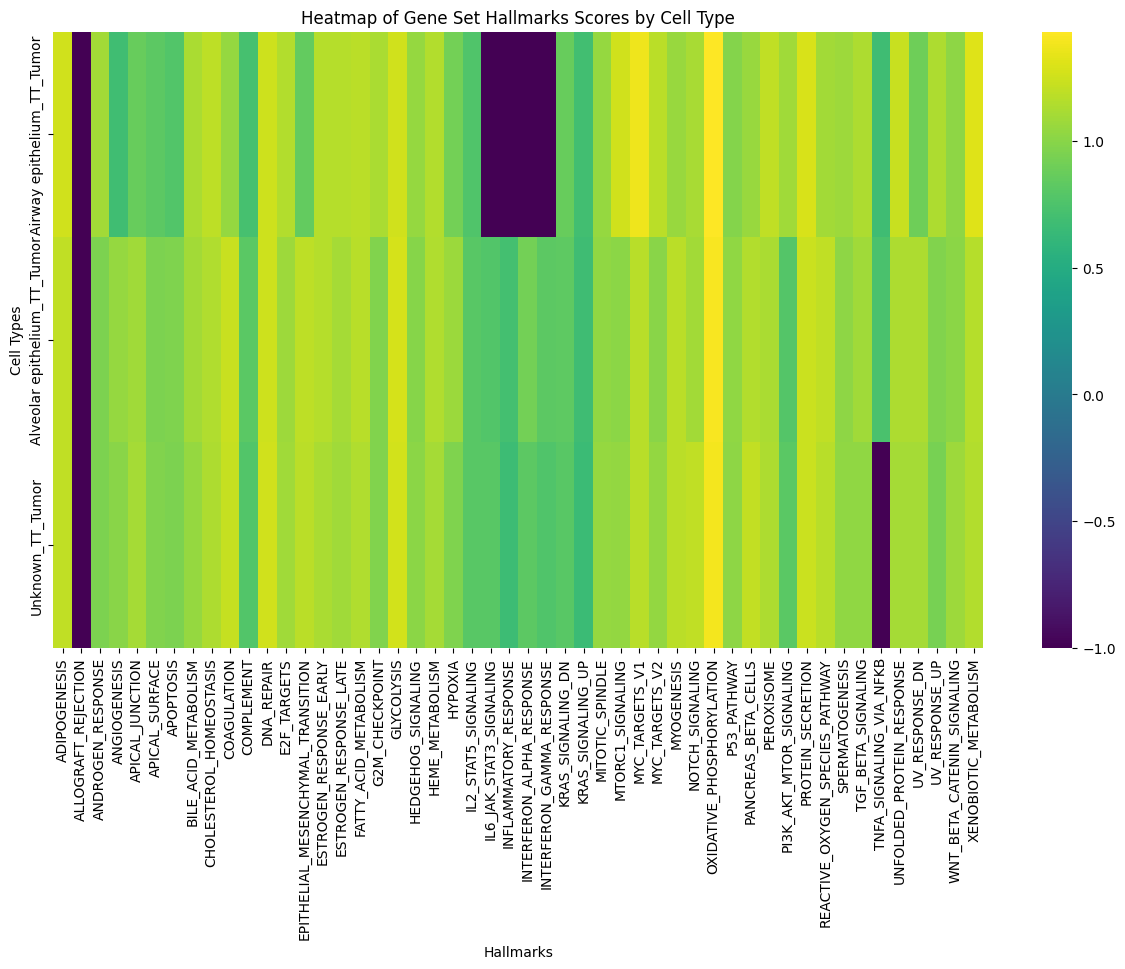

In [33]:
# Plotting the heatmap
combined_df_tumor = combined_df.loc[combined_df.index.str.split('_').str[-1] == 'Tumor']

plt.figure(figsize=(15, 8))
sns.heatmap(combined_df_tumor, cmap='viridis')
plt.title('Heatmap of Gene Set Hallmarks Scores by Cell Type')
plt.xlabel('Hallmarks')
plt.ylabel('Cell Types')
plt.show()

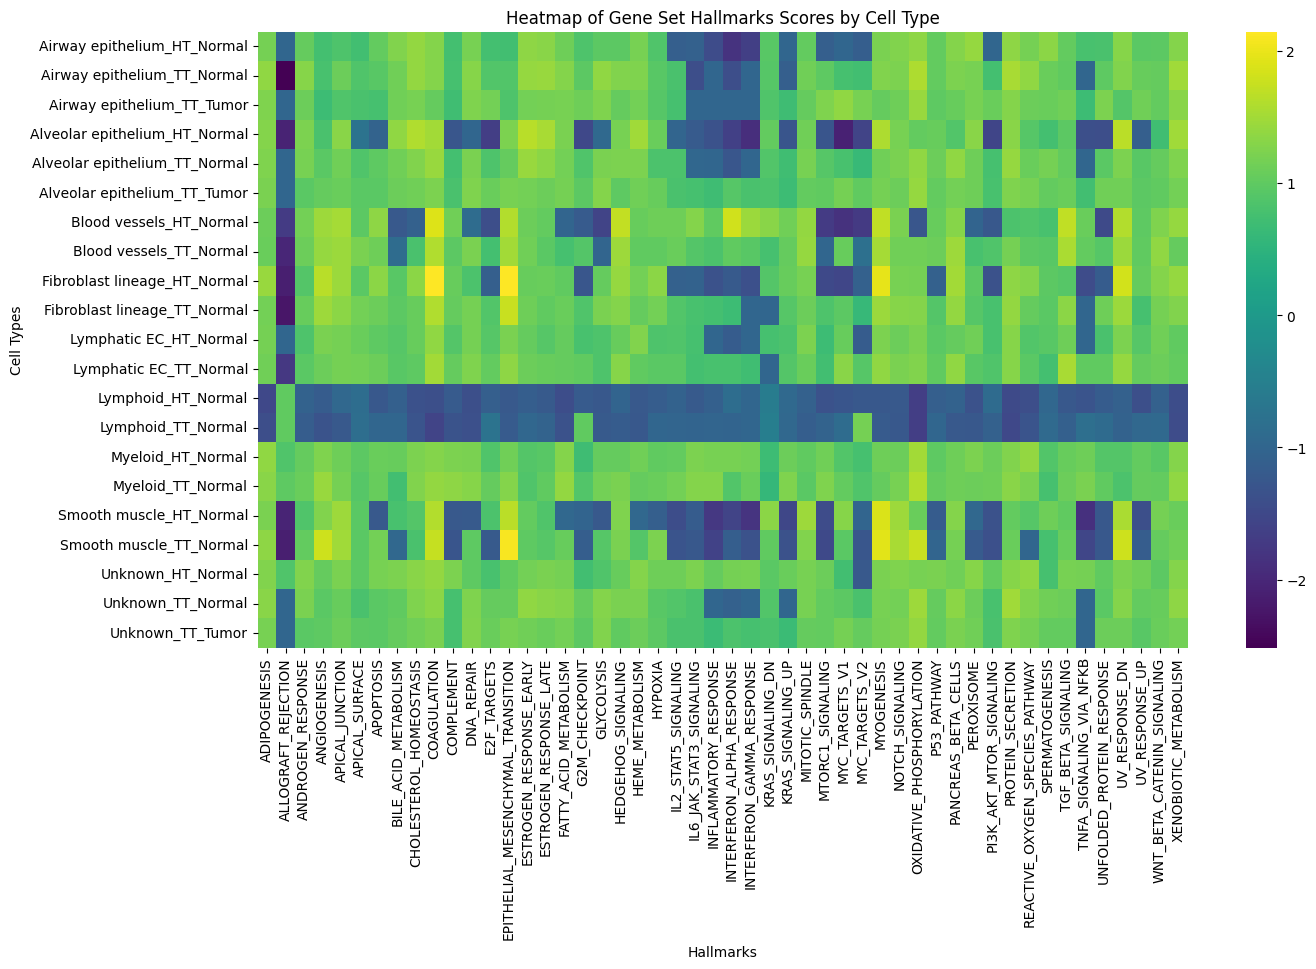

In [34]:
# Plotting the heatmap
combined_df_tumor = combined_df.loc[combined_df.index.str.split('_').str[-1] == 'Normal']

plt.figure(figsize=(15, 8))
sns.heatmap(combined_df, cmap='viridis')
plt.title('Heatmap of Gene Set Hallmarks Scores by Cell Type')
plt.xlabel('Hallmarks')
plt.ylabel('Cell Types')
plt.show()